<a href="https://colab.research.google.com/github/varJATIN/Amazon-Food-Reviews-Summarization/blob/master/Binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

random.seed = 2
#np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

In [3]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']

df_['Retinopathy grade'] = df['Retinopathy grade']
df_['Diseased']=[0 if df_['Retinopathy grade'][i]<1 else 1 for i in range(len(df_)) ]
train_df, val_df = train_test_split(df_, test_size = 0.15, random_state = 25);
train_df.head()

,Image name,Retinopathy grade,Diseased
72,IDRiD_073,2,1
256,IDRiD_257,0,0
290,IDRiD_291,1,1
311,IDRiD_312,0,0
389,IDRiD_390,4,1


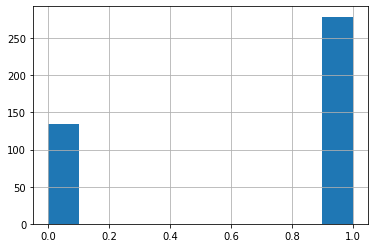

In [4]:
df_['Diseased'].hist()

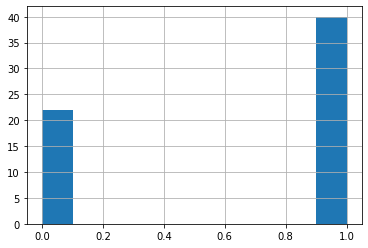

In [5]:
val_df['Diseased'].hist()

New Data Size: 478 Old Size: 351


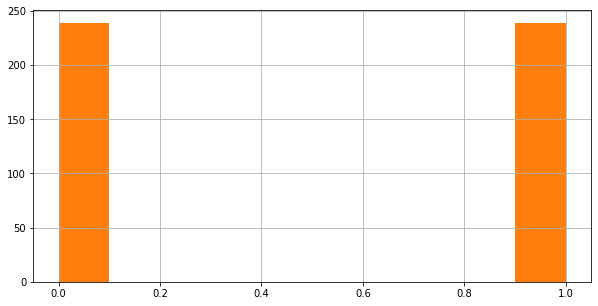

In [6]:
def balance_data(class_size, df):
    train_df = df.groupby(['Diseased']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Diseased'].hist(figsize = (10, 5))
    return train_df

train_df = balance_data(train_df.pivot_table(index='Diseased', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Diseased'].hist(figsize = (10, 5))

In [7]:
image_names = train_df['Image name'];
im_size = 224;

train_labels = [];
for label in train_df['Diseased']:
    for i in range(2): # 2 times for data augmentation
      train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((2*len(train_df['Image name']),im_size,im_size,3))

index=0
for image_name in image_names:
    #read image
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index,:,:,0:3] = img

    #rot 180
    train_images[index + 1] = np.rot90(np.rot90(img))
    
    index = index + 2

train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  956
(956, 224, 224, 3)
(956, 2)


array([[0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1]])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    #brightness_range=[0.,0.01],
    #zca_whitening	=True,
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(train_images)

In [9]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of val set ",len(val_image_names))
im_size = 224;

val_labels = [];
val_labels = val_df['Diseased'];

val_images = []
for image_name in val_image_names:
    img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);

val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of val set  62
(62, 224, 224, 3)
(62, 2)


In [10]:
val_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
val_datagen.fit(val_images)

In [34]:
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from keras.models import Model

In [55]:
def build_model(num_classes,model_name):
    random.seed = 135
    tf.seed = 135
    tf.random.set_seed(135)
    IMG_SIZE=224
    NUM_CLASSES=num_classes
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if model_name=='DenseNet121':
      model = DenseNet121(include_top=False, input_tensor=inputs, weights="imagenet")
    elif model_name=='EfficientNetB0':
      model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    elif model_name=='ResNet50':
      model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = Flatten(name="flatten")(model.output)
    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_1")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    #x = Dense(256, activation="relu", name="last_dense_2")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="DenseNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [69]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model_dense=build_model(2,'DenseNet121')
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist=model_dense.fit(train_datagen.flow(train_images, train_labels,batch_size=16,shuffle=True),steps_per_epoch=len(train_images) / 16,
               epochs = 10, callbacks = [early_stopping],validation_data=val_datagen.flow(val_images,val_labels,batch_size=16));

Epoch 1/10
59/59 [==============================] - 17s 208ms/step - loss: 0.7492 - accuracy: 0.6497 - val_loss: 0.5769 - val_accuracy: 0.7097
Epoch 2/10
59/59 [==============================] - 10s 174ms/step - loss: 0.4912 - accuracy: 0.7921 - val_loss: 0.9256 - val_accuracy: 0.5484
Epoch 3/10
59/59 [==============================] - 11s 176ms/step - loss: 0.3666 - accuracy: 0.8408 - val_loss: 0.8910 - val_accuracy: 0.6613
Epoch 4/10
59/59 [==============================] - 10s 173ms/step - loss: 0.3354 - accuracy: 0.8528 - val_loss: 0.6807 - val_accuracy: 0.6452
Epoch 5/10
59/59 [==============================] - 11s 177ms/step - loss: 0.2815 - accuracy: 0.8658 - val_loss: 0.6191 - val_accuracy: 0.6613
Epoch 6/10
59/59 [==============================] - 11s 177ms/step - loss: 0.3413 - accuracy: 0.8553 - val_loss: 0.5642 - val_accuracy: 0.6774
Epoch 7/10
59/59 [==============================] - 10s 174ms/step - loss: 0.2536 - accuracy: 0.8777 - val_loss: 0.6629 - val_accuracy: 0.6613

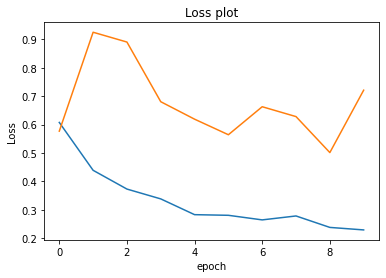

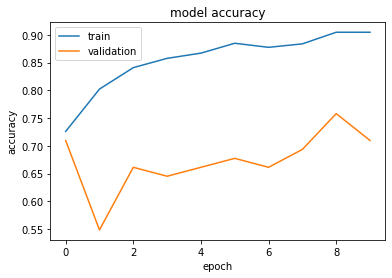

In [71]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [62]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model_resnet=build_model(2,'ResNet50')
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 6)
hist=model_resnet.fit(train_datagen.flow(train_images*255, train_labels,batch_size=16,shuffle=True),steps_per_epoch=len(train_images) / 16,
               epochs = 20, callbacks = [early_stopping],validation_data=val_datagen.flow(val_images*255,val_labels,batch_size=16));

Epoch 1/20
59/59 [==============================] - 14s 194ms/step - loss: 0.7249 - accuracy: 0.6966 - val_loss: 1.2787 - val_accuracy: 0.6129
Epoch 2/20
59/59 [==============================] - 11s 176ms/step - loss: 0.4117 - accuracy: 0.8325 - val_loss: 0.6905 - val_accuracy: 0.7097
Epoch 3/20
59/59 [==============================] - 11s 177ms/step - loss: 0.3429 - accuracy: 0.8778 - val_loss: 0.7971 - val_accuracy: 0.7097
Epoch 4/20
59/59 [==============================] - 11s 177ms/step - loss: 0.2435 - accuracy: 0.9018 - val_loss: 0.5339 - val_accuracy: 0.7581
Epoch 5/20
59/59 [==============================] - 11s 177ms/step - loss: 0.2373 - accuracy: 0.8962 - val_loss: 1.5072 - val_accuracy: 0.5968
Epoch 6/20
59/59 [==============================] - 11s 176ms/step - loss: 0.2899 - accuracy: 0.8944 - val_loss: 0.9329 - val_accuracy: 0.6774
Epoch 7/20
59/59 [==============================] - 11s 178ms/step - loss: 0.2162 - accuracy: 0.9008 - val_loss: 1.2098 - val_accuracy: 0.6452

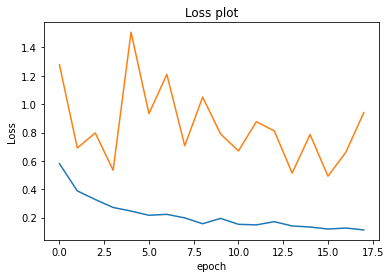

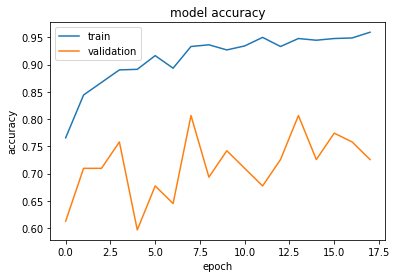

In [63]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()


In [54]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model_eff=build_model(2,'EfficientNetB0')
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 6)
hist=model_eff.fit(train_datagen.flow(train_images*255, train_labels,batch_size=16,shuffle=True),steps_per_epoch=len(train_images) / 16,
               epochs = 20, callbacks = [early_stopping],validation_data=val_datagen.flow(val_images*255,val_labels,batch_size=16));

Epoch 1/20
59/59 [==============================] - 16s 194ms/step - loss: 0.6357 - accuracy: 0.6664 - val_loss: 0.5028 - val_accuracy: 0.7258
Epoch 2/20
59/59 [==============================] - 10s 172ms/step - loss: 0.3655 - accuracy: 0.8361 - val_loss: 0.6267 - val_accuracy: 0.6613
Epoch 3/20
59/59 [==============================] - 10s 173ms/step - loss: 0.3103 - accuracy: 0.8609 - val_loss: 0.5898 - val_accuracy: 0.7258
Epoch 4/20
59/59 [==============================] - 10s 174ms/step - loss: 0.2619 - accuracy: 0.8746 - val_loss: 0.6707 - val_accuracy: 0.7258
Epoch 5/20
59/59 [==============================] - 10s 172ms/step - loss: 0.2397 - accuracy: 0.8973 - val_loss: 0.5843 - val_accuracy: 0.7419
Epoch 6/20
59/59 [==============================] - 10s 171ms/step - loss: 0.2418 - accuracy: 0.8996 - val_loss: 0.6549 - val_accuracy: 0.7097
Epoch 7/20
59/59 [==============================] - 10s 172ms/step - loss: 0.2038 - accuracy: 0.9190 - val_loss: 0.6394 - val_accuracy: 0.6935

#load test data


  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


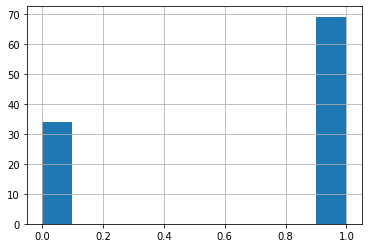

In [15]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df.head())
test_df['Diseased']=[0 if test_df['Retinopathy grade'][i]<1 else 1 for i in range(len(test_df)) ]
test_df['Diseased'].hist()

In [16]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))

test_labels = [];
test_labels = test_df['Diseased'];

test_images = []
for image_name in test_image_names:
    img = cv2.imread(test_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 224, 224, 3)
(103, 2)


# predicitons

4/4 [==============================] - 0s 48ms/step - loss: 0.8981 - accuracy: 0.7670
Test accuracy....
 densenet = 0.5922330021858215
 Resnet   = 0.6601941585540771
 EFFnet   = 0.7669903039932251
[[30  4]
 [20 49]]
0.7669902912621359


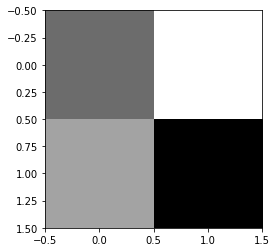

In [74]:
from sklearn.metrics import precision_score,accuracy_score

preds_dense = model_dense.evaluate(test_images, test_labels)
preds_resnet = model_resnet.evaluate(test_images*255, test_labels)
preds_eff = model_eff.evaluate(test_images*255, test_labels)

print("Test accuracy....")
print(" densenet = " + str(preds_dense[1]))
print(" Resnet   = " + str(preds_resnet[1]))
print(" EFFnet   = " + str(preds_eff[1]))

pred_y_dense=model_dense.predict(test_images)
pred_y_resnet=model_resnet.predict(test_images*255)
pred_y_eff=model_eff.predict(test_images*255)

pred_y_ens=0.3*pred_y_dense+2*pred_y_eff+0.5*pred_y_resnet
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_ens,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_ens,axis=1)))

## below is not part of code


In [18]:
from keras.utils.layer_utils import count_params
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:]=='bn':
    layer.trainable=False
    count+=1
print(count," layers of bn freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

121  layers of bn freezed


In [19]:
opt = keras.optimizers.Adam(learning_rate = 1e-7, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 3)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=16,shuffle=True),steps_per_epoch=len(train_images) / 16,
               epochs = 6,callbacks=[early_stopping]);

Epoch 1/6
59/59 [==============================] - 24s 249ms/step - loss: 0.1869 - accuracy: 0.9211
Epoch 2/6
59/59 [==============================] - 13s 223ms/step - loss: 0.1777 - accuracy: 0.9207
Epoch 3/6
59/59 [==============================] - 14s 225ms/step - loss: 0.2052 - accuracy: 0.9160
Epoch 4/6
59/59 [==============================] - 14s 225ms/step - loss: 0.1581 - accuracy: 0.9412
Epoch 5/6
59/59 [==============================] - 14s 225ms/step - loss: 0.1703 - accuracy: 0.9335
Epoch 6/6
59/59 [==============================] - 14s 226ms/step - loss: 0.1890 - accuracy: 0.9150


4/4 [==============================] - 2s 69ms/step - loss: 1.0602 - accuracy: 0.6699
Loss = 1.0602229833602905
Test accuracy = 0.6699029207229614
[[34  0]
 [34 35]]


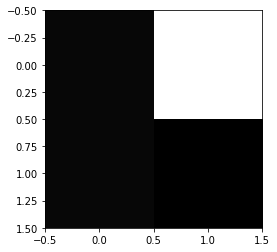

In [20]:
preds = model.evaluate(test_images, test_labels)
print("Loss = " + str(preds[0]))
print("Test accuracy = " + str(preds[1]))

pred_y=model.predict(test_images)
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')